In [85]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from catboost import CatBoostClassifier, Pool

Загрузим и изучим данные.

In [4]:
user_data = pd.read_csv('data//users.csv')
user_data.head()

,user_id,gender,age,country,city,exp_group,os,source
0,200,1,34,Russia,Degtyarsk,3,Android,ads
1,201,0,37,Russia,Abakan,0,Android,ads
2,202,1,17,Russia,Smolensk,4,Android,ads
3,203,0,18,Russia,Moscow,1,iOS,ads
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads


In [15]:
# посмотрим, сколько уникальных пользователей
user_data.user_id.count()

163205

In [5]:
post_data = pd.read_csv('data//posts.csv')
post_data.tail()

,post_id,text,topic
7018,7315,"OK, I would not normally watch a Farrelly brot...",movie
7019,7316,I give this movie 2 stars purely because of it...,movie
7020,7317,I cant believe this film was allowed to be mad...,movie
7021,7318,The version I saw of this film was the Blockbu...,movie
7022,7319,Piece of subtle art. Maybe a masterpiece. Doub...,movie


In [7]:
feed_data = pd.read_csv('data//feeds.csv')
feed_data.head()

,timestamp,user_id,post_id,action,target
0,2021-10-14 12:45:21,110257,652,view,0
1,2021-10-31 18:54:52,5320,3811,view,0
2,2021-11-17 18:21:38,107771,5536,view,0
3,2021-11-21 17:02:22,83907,2736,view,0
4,2021-10-13 18:35:53,303,6491,view,0


In [11]:
# посмотрим, сколько среди указанных таргетов 1
feed_data[feed_data['target'] == 1].target.count() / feed_data.shape[0]


0.1068128

In [13]:
# создадим фрейм, в который отберем всех user_id, для каждого до 30 активностей
feed_data = feed_data.groupby('user_id').apply(lambda x: x.sample(n=min(len(x), 30), random_state=42)).reset_index(drop=True)

In [16]:
# убедимся, что для каждого пользователя есть запись в таблице с активностью
feed_data.user_id.nunique() == user_data.user_id.count()

True

In [19]:
# посмотрим, сколько таргетов=1 есть в новой таблице с активностями
feed_data[feed_data['target'] == 1].target.count() / feed_data.target.count()

0.10498168308462708

In [20]:
# дабавим в таблицу с активностями информацию по пользователям и постам
df = pd.merge(feed_data, 
              user_data,
              on='user_id',
              how='left'
             )

In [21]:
df = pd.merge(df, 
             post_data,
             on='post_id',
              how='left'
             )

In [23]:
df.head()

,timestamp,user_id,post_id,action,target,gender,age,country,city,exp_group,os,source,text,topic
0,2021-11-13 19:38:59,200,6661,like,0,1,34,Russia,Degtyarsk,3,Android,ads,I grew up on this movie and I can remember whe...,movie
1,2021-12-24 13:56:32,200,6306,view,0,1,34,Russia,Degtyarsk,3,Android,ads,For a made for TV movie I thought that it was ...,movie
2,2021-12-29 15:04:47,200,5181,view,0,1,34,Russia,Degtyarsk,3,Android,ads,I saw this film when it was originally release...,movie
3,2021-12-24 13:43:12,200,4420,view,0,1,34,Russia,Degtyarsk,3,Android,ads,I got stuck in traffic (I live in Sicily) on t...,movie
4,2021-12-29 15:11:05,200,37,view,0,1,34,Russia,Degtyarsk,3,Android,ads,Bush budget seeks deep cutbacks\n\nPresident B...,business


In [24]:
# изучим типы данных в таблице
df.dtypes

timestamp    object
user_id       int64
post_id       int64
action       object
target        int64
gender        int64
age           int64
country      object
city         object
exp_group     int64
os           object
source       object
text         object
topic        object
dtype: object

In [25]:
# приведем дату к удобному формату и добавим столбцы с месяцем и датой в таблицу
df['timestamp'] = pd.to_datetime(df.timestamp)
df['month'] = df['timestamp'].dt.month
df['day'] = df['timestamp'].dt.day

In [26]:
df.head()

,timestamp,user_id,post_id,action,target,gender,age,country,city,exp_group,os,source,text,topic,month,day
0,2021-11-13 19:38:59,200,6661,like,0,1,34,Russia,Degtyarsk,3,Android,ads,I grew up on this movie and I can remember whe...,movie,11,13
1,2021-12-24 13:56:32,200,6306,view,0,1,34,Russia,Degtyarsk,3,Android,ads,For a made for TV movie I thought that it was ...,movie,12,24
2,2021-12-29 15:04:47,200,5181,view,0,1,34,Russia,Degtyarsk,3,Android,ads,I saw this film when it was originally release...,movie,12,29
3,2021-12-24 13:43:12,200,4420,view,0,1,34,Russia,Degtyarsk,3,Android,ads,I got stuck in traffic (I live in Sicily) on t...,movie,12,24
4,2021-12-29 15:11:05,200,37,view,0,1,34,Russia,Degtyarsk,3,Android,ads,Bush budget seeks deep cutbacks\n\nPresident B...,business,12,29


In [60]:
# посмотрим на значения признаков 'os', 'country', 'city', 'topic'
df.groupby('city').target.nunique()

city
Aadorf       2
Ababkovo     2
Abakan       2
Abalak       2
Abatskoye    2
            ..
Şirvan       2
Şırnak       2
Şəki         2
Şəmkir       2
Əmircan      2
Name: target, Length: 3915, dtype: int64

In [ ]:
dict(df.groupby('city').target.count())

<AxesSubplot:xlabel='os', ylabel='Count'>

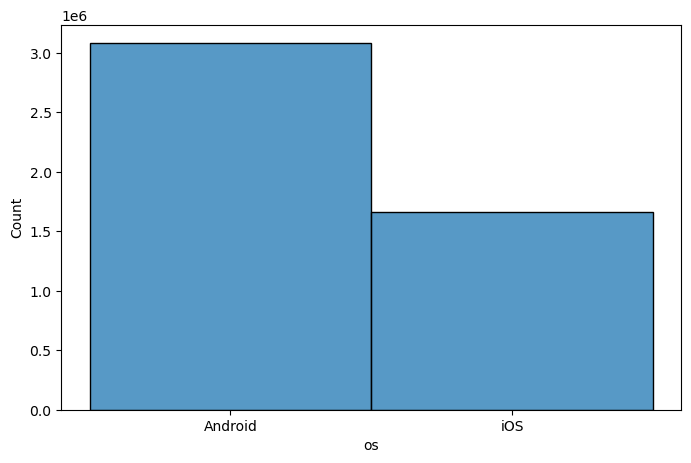

In [57]:
plt.figure(figsize=(8, 5))
sns.histplot(df.os)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

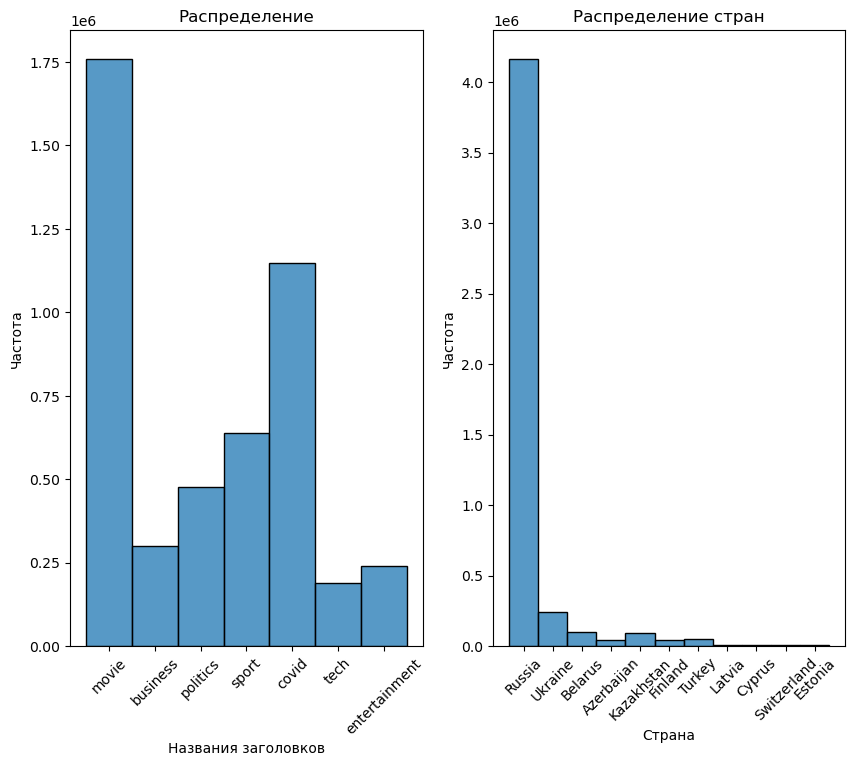

In [61]:
plt.figure(figsize=(10, 8))

plt.subplot(1, 2, 1)
sns.histplot(df.topic)
plt.xlabel('Названия заголовков')
plt.ylabel('Частота')
plt.title('Распределение')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.histplot(df.country)
plt.xlabel('Страна')
plt.ylabel('Частота')
plt.title('Распределение стран')
plt.xticks(rotation=45)

 Признак 'action' отражен в целевой переменной (по условию таргет = 1, если у поста был лайк). Удалим столбцы 'action', 'user_id','post_id', 'timestamp'. В качестве бейзлайна обучим catboost.

In [66]:
df = df.drop(['action', 'user_id','post_id', 'timestamp', 'text'], axis = 1)

In [67]:
df.shape

(4749981, 11)

In [68]:
df.dtypes

target        int64
gender        int64
age           int64
country      object
city         object
exp_group     int64
os           object
source       object
topic        object
month         int64
day           int64
dtype: object

In [88]:
# составим список категориальных признаков.
cat_features = list(df.select_dtypes(include=['object']).columns)
cat_features

['country', 'city', 'os', 'source', 'topic']

Данные отсортированы по user_id, замешаем перед обучением.

In [72]:
df = shuffle(df)

In [73]:
# разделим данные на трайн и тест (ручным способом)
train = df.iloc[:3000000].copy()
test = df.iloc[3000000:4000000].copy()

In [82]:
X_train = train.drop(['target'], axis = 1)
y_train = train.target

X_test = test.drop(['target'], axis = 1)
y_test = test.target

In [84]:
X_train.head()

,gender,age,country,city,exp_group,os,source,topic,month,day
3179341,0,21,Russia,Kasli,4,iOS,organic,movie,12,7
4611855,0,43,Russia,Moscow,1,Android,organic,sport,11,7
2993878,1,35,Russia,Syktyvkar,3,iOS,organic,covid,10,4
183037,1,18,Ukraine,Makiivka,0,Android,ads,sport,10,24
2119661,0,44,Russia,Miass,1,Android,ads,sport,11,3


In [101]:
catboost = CatBoostClassifier(iterations=500, cat_features=cat_features)

catboost.fit(X_train,
             y_train,
             )

Learning rate set to 0.5
0:	learn: 0.4037626	total: 1.15s	remaining: 9m 33s
1:	learn: 0.3471113	total: 2.15s	remaining: 8m 54s
2:	learn: 0.3347145	total: 3.08s	remaining: 8m 30s
3:	learn: 0.3291937	total: 4.25s	remaining: 8m 46s
4:	learn: 0.3276062	total: 5.23s	remaining: 8m 37s
5:	learn: 0.3268359	total: 6.15s	remaining: 8m 26s
6:	learn: 0.3257982	total: 6.77s	remaining: 7m 56s
7:	learn: 0.3256673	total: 7.79s	remaining: 7m 59s
8:	learn: 0.3254734	total: 8.72s	remaining: 7m 55s
9:	learn: 0.3237956	total: 9.5s	remaining: 7m 45s
10:	learn: 0.3236912	total: 10.2s	remaining: 7m 35s
11:	learn: 0.3233359	total: 11.4s	remaining: 7m 42s
12:	learn: 0.3232600	total: 12.2s	remaining: 7m 36s
13:	learn: 0.3231796	total: 13.3s	remaining: 7m 41s
14:	learn: 0.3230154	total: 14.3s	remaining: 7m 41s
15:	learn: 0.3229988	total: 15.2s	remaining: 7m 39s
16:	learn: 0.3229837	total: 16.1s	remaining: 7m 37s
17:	learn: 0.3229833	total: 16.8s	remaining: 7m 29s
18:	learn: 0.3229682	total: 17.6s	remaining: 7m 26

156:	learn: 0.3215829	total: 2m 38s	remaining: 5m 45s
157:	learn: 0.3215773	total: 2m 39s	remaining: 5m 44s
158:	learn: 0.3215709	total: 2m 40s	remaining: 5m 43s
159:	learn: 0.3215692	total: 2m 41s	remaining: 5m 42s
160:	learn: 0.3215663	total: 2m 42s	remaining: 5m 41s
161:	learn: 0.3215635	total: 2m 42s	remaining: 5m 39s
162:	learn: 0.3215591	total: 2m 44s	remaining: 5m 39s
163:	learn: 0.3215521	total: 2m 45s	remaining: 5m 38s
164:	learn: 0.3215471	total: 2m 46s	remaining: 5m 37s
165:	learn: 0.3215410	total: 2m 47s	remaining: 5m 36s
166:	learn: 0.3215362	total: 2m 48s	remaining: 5m 35s
167:	learn: 0.3215331	total: 2m 49s	remaining: 5m 34s
168:	learn: 0.3215321	total: 2m 49s	remaining: 5m 32s
169:	learn: 0.3215282	total: 2m 50s	remaining: 5m 31s
170:	learn: 0.3215254	total: 2m 51s	remaining: 5m 30s
171:	learn: 0.3215236	total: 2m 52s	remaining: 5m 29s
172:	learn: 0.3215196	total: 2m 53s	remaining: 5m 28s
173:	learn: 0.3215143	total: 2m 54s	remaining: 5m 26s
174:	learn: 0.3215098	total:

309:	learn: 0.3209921	total: 5m 18s	remaining: 3m 15s
310:	learn: 0.3209867	total: 5m 19s	remaining: 3m 14s
311:	learn: 0.3209798	total: 5m 20s	remaining: 3m 13s
312:	learn: 0.3209779	total: 5m 21s	remaining: 3m 12s
313:	learn: 0.3209743	total: 5m 22s	remaining: 3m 11s
314:	learn: 0.3209703	total: 5m 23s	remaining: 3m 10s
315:	learn: 0.3209680	total: 5m 24s	remaining: 3m 9s
316:	learn: 0.3209621	total: 5m 25s	remaining: 3m 8s
317:	learn: 0.3209615	total: 5m 27s	remaining: 3m 7s
318:	learn: 0.3209559	total: 5m 28s	remaining: 3m 6s
319:	learn: 0.3209503	total: 5m 29s	remaining: 3m 5s
320:	learn: 0.3209449	total: 5m 30s	remaining: 3m 4s
321:	learn: 0.3209437	total: 5m 31s	remaining: 3m 3s
322:	learn: 0.3209398	total: 5m 32s	remaining: 3m 2s
323:	learn: 0.3209368	total: 5m 33s	remaining: 3m 1s
324:	learn: 0.3209319	total: 5m 34s	remaining: 3m
325:	learn: 0.3209299	total: 5m 35s	remaining: 2m 59s
326:	learn: 0.3209288	total: 5m 36s	remaining: 2m 58s
327:	learn: 0.3209254	total: 5m 37s	remai

463:	learn: 0.3204382	total: 8m 11s	remaining: 38.1s
464:	learn: 0.3204321	total: 8m 12s	remaining: 37.1s
465:	learn: 0.3204272	total: 8m 13s	remaining: 36s
466:	learn: 0.3204250	total: 8m 14s	remaining: 35s
467:	learn: 0.3204231	total: 8m 15s	remaining: 33.9s
468:	learn: 0.3204180	total: 8m 16s	remaining: 32.8s
469:	learn: 0.3204121	total: 8m 17s	remaining: 31.8s
470:	learn: 0.3204102	total: 8m 18s	remaining: 30.7s
471:	learn: 0.3204095	total: 8m 19s	remaining: 29.7s
472:	learn: 0.3204068	total: 8m 20s	remaining: 28.6s
473:	learn: 0.3204046	total: 8m 21s	remaining: 27.5s
474:	learn: 0.3204011	total: 8m 22s	remaining: 26.4s
475:	learn: 0.3203941	total: 8m 23s	remaining: 25.4s
476:	learn: 0.3203890	total: 8m 24s	remaining: 24.3s
477:	learn: 0.3203869	total: 8m 25s	remaining: 23.3s
478:	learn: 0.3203846	total: 8m 27s	remaining: 22.2s
479:	learn: 0.3203805	total: 8m 28s	remaining: 21.2s
480:	learn: 0.3203756	total: 8m 29s	remaining: 20.1s
481:	learn: 0.3203725	total: 8m 30s	remaining: 19.

In [211]:
# проверим качество работы модели
pred = catboost.predict(X_test)
pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [217]:
pred_proba = catboost.predict_proba(X_test)
pred_proba

array([[0.84663701, 0.15336299],
       [0.85293493, 0.14706507],
       [0.8313753 , 0.1686247 ],
       ...,
       [0.85222051, 0.14777949],
       [0.90736392, 0.09263608],
       [0.8584284 , 0.1415716 ]])

In [218]:
pred_proba = pred_proba[:, 1]
pred_proba

array([0.15336299, 0.14706507, 0.1686247 , ..., 0.14777949, 0.09263608,
       0.1415716 ])

In [219]:
for count, i in enumerate(pred_proba):
    if i>=0.3:
        pred_proba[count] = 1
    else:
        pred_proba[count] = 0

In [220]:
pred_proba

array([0., 0., 0., ..., 0., 0., 0.])

In [221]:
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score

f1_score(y_test, pred), f1_score(y_test, pred_proba)

(0.00011391900358844861, 0.0008526360665056132)

In [222]:
accuracy_score(y_test, pred), precision_score(y_test, pred), recall_score(y_test, pred)

(0.894674, 0.24, 5.6973023273480004e-05)

In [223]:
accuracy_score(y_test, pred_proba), precision_score(y_test, pred_proba), recall_score(y_test, pred_proba)

(0.894535, 0.1859504132231405, 0.0004272976745511001)

Сохраним модель в форматах .cbm и .pkl

In [224]:
catboost.save_model('catboost_model_v1', format="cbm")

In [225]:
model = CatBoostClassifier()  # здесь не указываем параметры, которые были при обучении, в дампе модели все есть
model.load_model("catboost_model_v1")
model.predict(X_train)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [226]:
import pickle

In [227]:
filename = 'sklearn_model_v1.pkl'
pickle.dump(catboost, open(filename, 'wb'))
loaded_model = pickle.load(open(filename, 'rb'))

In [229]:
loaded_model.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)